In [3]:
# === TASK 3: RULE MINING SETUP ===
import pandas as pd
import networkx as nx
from collections import defaultdict, Counter
from itertools import combinations
import numpy as np

# Reload data if needed
file_path = '/kaggle/input/train-txt/train.txt'
df = pd.read_csv(file_path, sep='\s+', names=['head', 'relation', 'tail'])

print("="*70)
print("TASK 3: RULE MINING IN FAMILY KNOWLEDGE GRAPH")
print("="*70)

print(f"""
Dataset: {len(df)} triples, {df['relation'].nunique()} relation types

RULE TYPES WE'LL DISCOVER:
1. INVERSE RULES:      R1(X,Y) → R2(Y,X)
   Example: fatherOf(X,Y) → sonOf(Y,X) ∨ daughterOf(Y,X)

2. COMPOSITIONAL RULES (2-hop): R1(X,Y) ∧ R2(Y,Z) → R3(X,Z)
   Example: fatherOf(X,Y) ∧ fatherOf(Y,Z) → grandfatherOf(X,Z)

3. SYMMETRIC RULES:    R(X,Y) → R(Y,X)
   Example: brotherOf(X,Y) → brotherOf(Y,X) (if both male)

4. COMPLEX RULES (3+ relations): More elaborate patterns

METRICS:
- Support: Number of instances where the rule body is satisfied
- Confidence: P(head | body) = instances where full rule holds / support
""")

# Build efficient lookup structures
# Triple set for O(1) lookup
triple_set = set(zip(df['head'], df['relation'], df['tail']))

# Relation-specific edge lists
edges_by_relation = defaultdict(list)
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    edges_by_relation[r].append((h, t))

# Outgoing edges by node
outgoing = defaultdict(list)  # node -> [(relation, target), ...]
incoming = defaultdict(list)  # node -> [(relation, source), ...]

for h, r, t in zip(df['head'], df['relation'], df['tail']):
    outgoing[h].append((r, t))
    incoming[t].append((r, h))

print(f"\nRelation types: {sorted(df['relation'].unique())}")

TASK 3: RULE MINING IN FAMILY KNOWLEDGE GRAPH

Dataset: 13821 triples, 28 relation types

RULE TYPES WE'LL DISCOVER:
1. INVERSE RULES:      R1(X,Y) → R2(Y,X)
   Example: fatherOf(X,Y) → sonOf(Y,X) ∨ daughterOf(Y,X)

2. COMPOSITIONAL RULES (2-hop): R1(X,Y) ∧ R2(Y,Z) → R3(X,Z)
   Example: fatherOf(X,Y) ∧ fatherOf(Y,Z) → grandfatherOf(X,Z)

3. SYMMETRIC RULES:    R(X,Y) → R(Y,X)
   Example: brotherOf(X,Y) → brotherOf(Y,X) (if both male)

4. COMPLEX RULES (3+ relations): More elaborate patterns

METRICS:
- Support: Number of instances where the rule body is satisfied
- Confidence: P(head | body) = instances where full rule holds / support


Relation types: ['auntOf', 'boyCousinOf', 'boyFirstCousinOnceRemovedOf', 'boySecondCousinOf', 'brotherOf', 'daughterOf', 'fatherOf', 'girlCousinOf', 'girlFirstCousinOnceRemovedOf', 'girlSecondCousinOf', 'granddaughterOf', 'grandfatherOf', 'grandmotherOf', 'grandsonOf', 'greatAuntOf', 'greatGranddaughterOf', 'greatGrandfatherOf', 'greatGrandmotherOf', 'g

<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_55/1216063950.py:10: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep='\s+', names=['head', 'relation', 'tail'])


In [16]:
# === RULE TYPE 1: INVERSE RULES ===
# R1(X,Y) → R2(Y,X)

print("="*70)
print("RULE TYPE 1: INVERSE RULES")
print("="*70)
print("Pattern: R1(X,Y) → R2(Y,X)")
print("Example: motherOf(Alice, Bob) → sonOf(Bob, Alice) OR daughterOf(Bob, Alice)\n")

# Define inverse pairs with gender handling
inverse_map = {
    'fatherOf': ['sonOf', 'daughterOf'],
    'motherOf': ['sonOf', 'daughterOf'],
    'grandfatherOf': ['grandsonOf', 'granddaughterOf'],
    'grandmotherOf': ['grandsonOf', 'granddaughterOf'],
    'greatGrandfatherOf': ['greatGrandsonOf', 'greatGranddaughterOf'],
    'greatGrandmotherOf': ['greatGrandsonOf', 'greatGranddaughterOf'],
    'uncleOf': ['nephewOf', 'nieceOf'],
    'auntOf': ['nephewOf', 'nieceOf'],
    'greatUncleOf': ['nephewOf', 'nieceOf'],  # or could be more specific
    'greatAuntOf': ['nephewOf', 'nieceOf'],
    'brotherOf': ['brotherOf', 'sisterOf'],  # sibling's sibling
    'sisterOf': ['brotherOf', 'sisterOf'],
    'sonOf': ['fatherOf', 'motherOf'],
    'daughterOf': ['fatherOf', 'motherOf'],
    'grandsonOf': ['grandfatherOf', 'grandmotherOf'],
    'granddaughterOf': ['grandfatherOf', 'grandmotherOf'],
    'nephewOf': ['uncleOf', 'auntOf'],
    'nieceOf': ['uncleOf', 'auntOf'],
}

def mine_inverse_rules_v2(df, triple_set, inverse_map):
    results = []
    for r1, possible_inverses in inverse_map.items():
        r1_edges = [(h, t) for h, r, t in zip(df['head'], df['relation'], df['tail']) if r == r1]
        support = len(r1_edges)
        
        if support == 0:
            continue
        
        # Check if ANY of the possible inverses exists
        hits = 0
        examples = []
        for x, y in r1_edges:
            for r2 in possible_inverses:
                if (y, r2, x) in triple_set:
                    hits += 1
                    if len(examples) < 3:
                        examples.append((x, r1, y, r2))
                    break  # Count once per edge
        
        confidence = hits / support if support > 0 else 0
        results.append({
            'rule': f"{r1}(X,Y) → {'/'.join(possible_inverses)}(Y,X)",
            'r1': r1,
            'possible_inverses': possible_inverses,
            'support': support,
            'hits': hits,
            'confidence': confidence,
            'examples': examples
        })
    
    return sorted(results, key=lambda x: (-x['confidence'], -x['support']))

# === THIS IS THE LINE YOU WERE MISSING ===
inverse_rules = mine_inverse_rules_v2(df, triple_set, inverse_map)

print(f"Found {len(inverse_rules)} inverse rule patterns:\n")
print(f"{'Rule':<55} {'Support':>8} {'Hits':>8} {'Conf':>8}")
print("-" * 81)

for rule in inverse_rules[:15]:
    print(f"{rule['rule']:<55} {rule['support']:>8} {rule['hits']:>8} {rule['confidence']:>8.2%}")

# Show examples for top rules
print("\n" + "-"*70)
print("EXAMPLES OF INVERSE RULES:")
print("-"*70)

for rule in inverse_rules[:5]:
    if rule['examples']:
        print(f"\n{rule['rule']} (conf={rule['confidence']:.2%})")
        for ex in rule['examples'][:2]:
            print(f"  {ex[0]} --{ex[1]}--> {ex[2]}  ⟹  {ex[2]} --{ex[3]}--> {ex[0]}")

RULE TYPE 1: INVERSE RULES
Pattern: R1(X,Y) → R2(Y,X)
Example: motherOf(Alice, Bob) → sonOf(Bob, Alice) OR daughterOf(Bob, Alice)

Found 18 inverse rule patterns:

Rule                                                     Support     Hits     Conf
---------------------------------------------------------------------------------
grandsonOf(X,Y) → grandfatherOf/grandmotherOf(Y,X)           814      814  100.00%
grandfatherOf(X,Y) → grandsonOf/granddaughterOf(Y,X)         813      813  100.00%
grandmotherOf(X,Y) → grandsonOf/granddaughterOf(Y,X)         813      813  100.00%
granddaughterOf(X,Y) → grandfatherOf/grandmotherOf(Y,X)      812      812  100.00%
sisterOf(X,Y) → brotherOf/sisterOf(Y,X)                      636      636  100.00%
greatGrandfatherOf(X,Y) → greatGrandsonOf/greatGranddaughterOf(Y,X)      617      617  100.00%
greatGrandmotherOf(X,Y) → greatGrandsonOf/greatGranddaughterOf(Y,X)      617      617  100.00%
brotherOf(X,Y) → brotherOf/sisterOf(Y,X)                     570  

In [5]:
# === RULE TYPE 2: COMPOSITIONAL RULES (2-HOP) ===
# R1(X,Y) ∧ R2(Y,Z) → R3(X,Z)

print("\n" + "="*70)
print("RULE TYPE 2: COMPOSITIONAL RULES (2-HOP)")
print("="*70)
print("Pattern: R1(X,Y) ∧ R2(Y,Z) → R3(X,Z)")
print("Example: fatherOf(X,Y) ∧ fatherOf(Y,Z) → grandfatherOf(X,Z)\n")

def mine_compositional_rules(df, triple_set, outgoing, min_support=20, min_confidence=0.8):
    """
    Find rules of the form: R1(X,Y) ∧ R2(Y,Z) → R3(X,Z)
    """
    relations = df['relation'].unique()
    rules = []
    
    # For each pair of relations (R1, R2)
    for r1 in relations:
        for r2 in relations:
            # Find all (X, Y, Z) where R1(X,Y) and R2(Y,Z)
            body_instances = []
            
            for h, r, t in zip(df['head'], df['relation'], df['tail']):
                if r == r1:
                    x, y = h, t
                    # Find all Z where R2(Y,Z)
                    for rel, z in outgoing[y]:
                        if rel == r2:
                            body_instances.append((x, y, z))
            
            support = len(body_instances)
            if support < min_support:
                continue
            
            # For each possible head relation R3
            for r3 in relations:
                hits = 0
                examples = []
                
                for x, y, z in body_instances:
                    if (x, r3, z) in triple_set:
                        hits += 1
                        if len(examples) < 3:
                            examples.append((x, y, z))
                
                if hits > 0:
                    confidence = hits / support
                    if confidence >= min_confidence:
                        rules.append({
                            'rule': f"{r1}(X,Y) ∧ {r2}(Y,Z) → {r3}(X,Z)",
                            'r1': r1,
                            'r2': r2,
                            'r3': r3,
                            'support': support,
                            'hits': hits,
                            'confidence': confidence,
                            'examples': examples
                        })
    
    return sorted(rules, key=lambda x: (-x['confidence'], -x['support']))

compositional_rules = mine_compositional_rules(df, triple_set, outgoing, min_support=20, min_confidence=0.9)

print(f"Found {len(compositional_rules)} high-confidence compositional rules:\n")
print(f"{'Rule':<65} {'Support':>8} {'Conf':>8}")
print("-" * 83)

for rule in compositional_rules[:20]:  # Top 20
    print(f"{rule['rule']:<65} {rule['support']:>8} {rule['confidence']:>8.2%}")

# Group by semantic meaning
print("\n" + "-"*70)
print("SEMANTIC GROUPING OF COMPOSITIONAL RULES:")
print("-"*70)

# Grandparent rules
grandparent_rules = [r for r in compositional_rules if 'grand' in r['r3'].lower()]
print(f"\n1. GRANDPARENT RULES ({len(grandparent_rules)} found):")
for rule in grandparent_rules[:5]:
    print(f"   {rule['rule']}")
    print(f"      Support: {rule['support']}, Confidence: {rule['confidence']:.2%}")

# Great-grandparent rules
great_rules = [r for r in compositional_rules if 'great' in r['r3'].lower()]
print(f"\n2. GREAT-GRANDPARENT RULES ({len(great_rules)} found):")
for rule in great_rules[:5]:
    print(f"   {rule['rule']}")
    print(f"      Support: {rule['support']}, Confidence: {rule['confidence']:.2%}")

# Sibling rules
sibling_rules = [r for r in compositional_rules if 'brother' in r['r3'].lower() or 'sister' in r['r3'].lower()]
print(f"\n3. SIBLING RULES ({len(sibling_rules)} found):")
for rule in sibling_rules[:5]:
    print(f"   {rule['rule']}")
    print(f"      Support: {rule['support']}, Confidence: {rule['confidence']:.2%}")

# Uncle/Aunt rules
uncle_aunt_rules = [r for r in compositional_rules if 'uncle' in r['r3'].lower() or 'aunt' in r['r3'].lower()]
print(f"\n4. UNCLE/AUNT RULES ({len(uncle_aunt_rules)} found):")
for rule in uncle_aunt_rules[:5]:
    print(f"   {rule['rule']}")
    print(f"      Support: {rule['support']}, Confidence: {rule['confidence']:.2%}")


RULE TYPE 2: COMPOSITIONAL RULES (2-HOP)
Pattern: R1(X,Y) ∧ R2(Y,Z) → R3(X,Z)
Example: fatherOf(X,Y) ∧ fatherOf(Y,Z) → grandfatherOf(X,Z)

Found 224 high-confidence compositional rules:

Rule                                                               Support     Conf
-----------------------------------------------------------------------------------
sisterOf(X,Y) ∧ granddaughterOf(Y,Z) → granddaughterOf(X,Z)            772  100.00%
grandmotherOf(X,Y) ∧ sisterOf(Y,Z) → grandmotherOf(X,Z)                747  100.00%
grandfatherOf(X,Y) ∧ sisterOf(Y,Z) → grandfatherOf(X,Z)                747  100.00%
sisterOf(X,Y) ∧ grandsonOf(Y,Z) → granddaughterOf(X,Z)                 722  100.00%
brotherOf(X,Y) ∧ granddaughterOf(Y,Z) → grandsonOf(X,Z)                722  100.00%
grandmotherOf(X,Y) ∧ brotherOf(Y,Z) → grandmotherOf(X,Z)               673  100.00%
grandfatherOf(X,Y) ∧ brotherOf(Y,Z) → grandfatherOf(X,Z)               673  100.00%
brotherOf(X,Y) ∧ grandsonOf(Y,Z) → grandsonOf(X,Z)      

In [18]:
# === RULE TYPE 3: SYMMETRIC RULES ===
# R(X,Y) → R(Y,X)

print("\n" + "="*70)
print("RULE TYPE 3: SYMMETRIC RULES")
print("="*70)
print("Pattern: R(X,Y) → R(Y,X)")
print("Question: For which relations does R(A,B) imply R(B,A)?\n")

def mine_symmetric_rules(df, triple_set, min_support=20):
    """
    Find rules where R(X,Y) → R(Y,X) (same relation both directions)
    """
    relations = df['relation'].unique()
    symmetric_rules = []
    
    for r in relations:
        r_edges = [(h, t) for h, rel, t in zip(df['head'], df['relation'], df['tail']) if rel == r]
        support = len(r_edges)
        
        if support < min_support:
            continue
        
        hits = 0
        examples = []
        
        for x, y in r_edges:
            if (y, r, x) in triple_set:
                hits += 1
                if len(examples) < 3:
                    examples.append((x, y))
        
        confidence = hits / support if support > 0 else 0
        
        symmetric_rules.append({
            'relation': r,
            'rule': f"{r}(X,Y) → {r}(Y,X)",
            'support': support,
            'hits': hits,
            'confidence': confidence,
            'is_symmetric': confidence > 0.9,
            'examples': examples
        })
    
    return sorted(symmetric_rules, key=lambda x: -x['confidence'])

symmetric_rules = mine_symmetric_rules(df, triple_set)

print(f"{'Relation':<35} {'Support':>8} {'Symmetric':>12} {'Confidence':>12}")
print("-" * 70)

for rule in symmetric_rules:
    print(f"{rule['relation']:<35} {rule['support']:>8} {rule['hits']:>12} {rule['confidence']:>12.2%}")

# === THE KEY INSIGHT ===
print("\n" + "="*70)
print("CRITICAL INSIGHT: Why Sibling Relations Are Only ~50% Symmetric")
print("="*70)

# Analyze sisterOf specifically
sister_edges = [(h, t) for h, r, t in zip(df['head'], df['relation'], df['tail']) if r == 'sisterOf']
sister_to_sister = sum(1 for h, t in sister_edges if (t, 'sisterOf', h) in triple_set)
sister_to_brother = sum(1 for h, t in sister_edges if (t, 'brotherOf', h) in triple_set)

print(f"""
For sisterOf(A, B):
  - A is ALWAYS female (the relation encodes A's gender)
  - B can be male OR female (B is just A's sibling)

Therefore:
  - sisterOf(A,B) ∧ sisterOf(B,A) only when BOTH are female
  - sisterOf(A,B) ∧ brotherOf(B,A) when A is female, B is male

Verification from data:
  Total sisterOf edges:              {len(sister_edges)}
  Sister→Sister (symmetric):         {sister_to_sister} ({sister_to_sister/len(sister_edges)*100:.1f}%)
  Sister→Brother (cross-gender):     {sister_to_brother} ({sister_to_brother/len(sister_edges)*100:.1f}%)
  
The ~50% symmetry rate indicates roughly equal male/female siblings!
This is NOT a data error - it's the expected behavior given gendered relation names.
""")

# Same analysis for brotherOf
brother_edges = [(h, t) for h, r, t in zip(df['head'], df['relation'], df['tail']) if r == 'brotherOf']
brother_to_brother = sum(1 for h, t in brother_edges if (t, 'brotherOf', h) in triple_set)
brother_to_sister = sum(1 for h, t in brother_edges if (t, 'sisterOf', h) in triple_set)

print(f"""For brotherOf(A, B):
  Total brotherOf edges:             {len(brother_edges)}
  Brother→Brother (symmetric):       {brother_to_brother} ({brother_to_brother/len(brother_edges)*100:.1f}%)
  Brother→Sister (cross-gender):     {brother_to_sister} ({brother_to_sister/len(brother_edges)*100:.1f}%)
""")

# Check if sibling relations are COMPLETE (every sisterOf has either sisterOf or brotherOf back)
complete_sister = sum(1 for h, t in sister_edges if (t, 'sisterOf', h) in triple_set or (t, 'brotherOf', h) in triple_set)
complete_brother = sum(1 for h, t in brother_edges if (t, 'brotherOf', h) in triple_set or (t, 'sisterOf', h) in triple_set)

print(f"""Completeness Check (sibling relation has ANY inverse):
  sisterOf with inverse:  {complete_sister}/{len(sister_edges)} ({complete_sister/len(sister_edges)*100:.1f}%)
  brotherOf with inverse: {complete_brother}/{len(brother_edges)} ({complete_brother/len(brother_edges)*100:.1f}%)
""")


RULE TYPE 3: SYMMETRIC RULES
Pattern: R(X,Y) → R(Y,X)
Question: For which relations does R(A,B) imply R(B,A)?

Relation                             Support    Symmetric   Confidence
----------------------------------------------------------------------
girlCousinOf                             445          236       53.03%
sisterOf                                 636          328       51.57%
boyCousinOf                              391          182       46.55%
brotherOf                                570          262       45.96%
boySecondCousinOf                         68           28       41.18%
girlSecondCousinOf                        62           22       35.48%
secondAuntOf                             175            0        0.00%
daughterOf                               628            0        0.00%
granddaughterOf                          812            0        0.00%
nieceOf                                  496            0        0.00%
motherOf                            

In [7]:
# === RULE TYPE 4: COMPLEX RULES (3-HOP) ===
# R1(X,Y) ∧ R2(Y,Z) ∧ R3(Z,W) → R4(X,W)

print("\n" + "="*70)
print("RULE TYPE 4: COMPLEX RULES (3-HOP)")
print("="*70)
print("Pattern: R1(X,Y) ∧ R2(Y,Z) ∧ R3(Z,W) → R4(X,W)")
print("Example: fatherOf(X,Y) ∧ fatherOf(Y,Z) ∧ fatherOf(Z,W) → greatGrandfatherOf(X,W)\n")

def mine_3hop_rules(df, triple_set, outgoing, target_relations=None, min_support=10, min_confidence=0.9):
    """
    Find rules of the form: R1(X,Y) ∧ R2(Y,Z) ∧ R3(Z,W) → R4(X,W)
    This is computationally expensive, so we focus on specific patterns.
    """
    rules = []
    
    # Focus on parent relations for 3-hop (great-grandparent patterns)
    parent_rels = ['fatherOf', 'motherOf']
    child_rels = ['sonOf', 'daughterOf']
    
    if target_relations is None:
        target_relations = ['greatGrandfatherOf', 'greatGrandmotherOf', 
                           'greatGrandsonOf', 'greatGranddaughterOf']
    
    for r1 in parent_rels:
        for r2 in parent_rels:
            for r3 in parent_rels:
                # Find all (X, Y, Z, W) paths
                body_instances = []
                
                for h1, rel1, t1 in zip(df['head'], df['relation'], df['tail']):
                    if rel1 == r1:
                        x, y = h1, t1
                        for rel2, z in outgoing[y]:
                            if rel2 == r2:
                                for rel3, w in outgoing[z]:
                                    if rel3 == r3:
                                        body_instances.append((x, y, z, w))
                
                support = len(body_instances)
                if support < min_support:
                    continue
                
                # Check each target relation
                for r4 in target_relations:
                    hits = 0
                    examples = []
                    
                    for x, y, z, w in body_instances:
                        if (x, r4, w) in triple_set:
                            hits += 1
                            if len(examples) < 3:
                                examples.append((x, y, z, w))
                    
                    if hits > 0:
                        confidence = hits / support
                        if confidence >= min_confidence:
                            rules.append({
                                'rule': f"{r1}(X,Y) ∧ {r2}(Y,Z) ∧ {r3}(Z,W) → {r4}(X,W)",
                                'r1': r1, 'r2': r2, 'r3': r3, 'r4': r4,
                                'support': support,
                                'hits': hits,
                                'confidence': confidence,
                                'examples': examples
                            })
    
    return sorted(rules, key=lambda x: (-x['confidence'], -x['support']))

complex_rules = mine_3hop_rules(df, triple_set, outgoing)

print(f"Found {len(complex_rules)} high-confidence 3-hop rules:\n")
print(f"{'Rule':<75} {'Support':>8} {'Conf':>8}")
print("-" * 93)

for rule in complex_rules[:15]:
    print(f"{rule['rule']:<75} {rule['support']:>8} {rule['confidence']:>8.2%}")

# Show concrete examples
print("\n" + "-"*70)
print("CONCRETE EXAMPLES:")
print("-"*70)

for rule in complex_rules[:3]:
    print(f"\n{rule['rule']}")
    for ex in rule['examples'][:2]:
        x, y, z, w = ex
        print(f"  {x} → {y} → {z} → {w}")
        print(f"  Therefore: {x} --{rule['r4']}--> {w}")


RULE TYPE 4: COMPLEX RULES (3-HOP)
Pattern: R1(X,Y) ∧ R2(Y,Z) ∧ R3(Z,W) → R4(X,W)
Example: fatherOf(X,Y) ∧ fatherOf(Y,Z) ∧ fatherOf(Z,W) → greatGrandfatherOf(X,W)

Found 8 high-confidence 3-hop rules:

Rule                                                                         Support     Conf
---------------------------------------------------------------------------------------------
fatherOf(X,Y) ∧ fatherOf(Y,Z) ∧ fatherOf(Z,W) → greatGrandfatherOf(X,W)          129  100.00%
motherOf(X,Y) ∧ fatherOf(Y,Z) ∧ fatherOf(Z,W) → greatGrandmotherOf(X,W)          129  100.00%
fatherOf(X,Y) ∧ motherOf(Y,Z) ∧ fatherOf(Z,W) → greatGrandfatherOf(X,W)          121  100.00%
motherOf(X,Y) ∧ motherOf(Y,Z) ∧ fatherOf(Z,W) → greatGrandmotherOf(X,W)          121  100.00%
fatherOf(X,Y) ∧ fatherOf(Y,Z) ∧ motherOf(Z,W) → greatGrandfatherOf(X,W)           99  100.00%
motherOf(X,Y) ∧ fatherOf(Y,Z) ∧ motherOf(Z,W) → greatGrandmotherOf(X,W)           99  100.00%
fatherOf(X,Y) ∧ motherOf(Y,Z) ∧ motherOf(Z,W)

In [8]:
# === BONUS: GENDER-AWARE RULES ===
# Rules that depend on gender of participants

print("\n" + "="*70)
print("BONUS: GENDER-AWARE COMPOSITIONAL RULES")
print("="*70)
print("""
Some family rules depend on gender:
- If X is father of Y, and Y is sibling of Z, then X is father of Z
- If X is mother of Y, and Y has brother Z, then X is mother of Z
- Parent's brother → uncle (not aunt)
- Parent's sister → aunt (not uncle)
""")

# Specific gender-aware rules to verify
gender_rules = [
    # Uncle/Aunt rules
    {
        'name': "Parent's brother is uncle",
        'body': [('fatherOf', 'motherOf'), ('brotherOf',)],
        'head': 'uncleOf',
        'pattern': "parentOf(X,Y) ∧ brotherOf(X,Z) → uncleOf(Z,Y)"
    },
    {
        'name': "Parent's sister is aunt", 
        'body': [('fatherOf', 'motherOf'), ('sisterOf',)],
        'head': 'auntOf',
        'pattern': "parentOf(X,Y) ∧ sisterOf(X,Z) → auntOf(Z,Y)"
    },
]

def verify_uncle_aunt_rule(df, triple_set, outgoing, parent_rels, sibling_rel, expected_rel):
    """Verify: parent(X,Y) ∧ sibling(X,Z) → relation(Z,Y)"""
    instances = []
    hits = 0
    examples = []
    
    for h, r, t in zip(df['head'], df['relation'], df['tail']):
        if r in parent_rels:
            x, y = h, t  # X is parent of Y
            # Find siblings of X
            for rel, z in outgoing[x]:
                if rel == sibling_rel:
                    instances.append((x, y, z))
                    # Check if Z has expected_rel to Y
                    if (z, expected_rel, y) in triple_set:
                        hits += 1
                        if len(examples) < 3:
                            examples.append((x, y, z))
    
    support = len(instances)
    confidence = hits / support if support > 0 else 0
    return support, hits, confidence, examples

# Verify uncle rule: parent(X,Y) ∧ brother(X,Z) → uncle(Z,Y)
parent_rels = ['fatherOf', 'motherOf']
support, hits, conf, examples = verify_uncle_aunt_rule(df, triple_set, outgoing, parent_rels, 'brotherOf', 'uncleOf')
print(f"\nRule: parentOf(X,Y) ∧ brotherOf(X,Z) → uncleOf(Z,Y)")
print(f"  Support: {support}, Hits: {hits}, Confidence: {conf:.2%}")
if examples:
    for ex in examples[:2]:
        print(f"  Example: {ex[0]} is parent of {ex[1]}, {ex[0]} has brother {ex[2]} → {ex[2]} is uncle of {ex[1]}")

# Verify aunt rule: parent(X,Y) ∧ sister(X,Z) → aunt(Z,Y)
support, hits, conf, examples = verify_uncle_aunt_rule(df, triple_set, outgoing, parent_rels, 'sisterOf', 'auntOf')
print(f"\nRule: parentOf(X,Y) ∧ sisterOf(X,Z) → auntOf(Z,Y)")
print(f"  Support: {support}, Hits: {hits}, Confidence: {conf:.2%}")
if examples:
    for ex in examples[:2]:
        print(f"  Example: {ex[0]} is parent of {ex[1]}, {ex[0]} has sister {ex[2]} → {ex[2]} is aunt of {ex[1]}")

# Nephew/Niece rules
print("\n" + "-"*70)
print("NEPHEW/NIECE RULES:")
print("-"*70)

def verify_nephew_niece_rule(df, triple_set, outgoing, sibling_rel, child_rel, expected_rel):
    """Verify: sibling(X,Y) ∧ child(Y,Z) → relation(Z,X)"""
    instances = []
    hits = 0
    examples = []
    
    for h, r, t in zip(df['head'], df['relation'], df['tail']):
        if r == sibling_rel:
            x, y = h, t  # X has sibling Y
            # Find children of Y
            for h2, r2, t2 in zip(df['head'], df['relation'], df['tail']):
                if r2 == child_rel and h2 == y:
                    z = t2  # Z is child of Y
                    instances.append((x, y, z))
                    # Check if Z has expected_rel to X
                    if (z, expected_rel, x) in triple_set:
                        hits += 1
                        if len(examples) < 3:
                            examples.append((x, y, z))
    
    support = len(instances)
    confidence = hits / support if support > 0 else 0
    return support, hits, confidence, examples

# Brother's son is nephew
support, hits, conf, examples = verify_nephew_niece_rule(df, triple_set, outgoing, 'brotherOf', 'fatherOf', 'nephewOf')
print(f"\nRule: brotherOf(X,Y) ∧ fatherOf(Y,Z) → nephewOf(Z,X)")
print(f"  Support: {support}, Hits: {hits}, Confidence: {conf:.2%}")

# Sister's daughter is niece
support, hits, conf, examples = verify_nephew_niece_rule(df, triple_set, outgoing, 'sisterOf', 'motherOf', 'nieceOf')
print(f"\nRule: sisterOf(X,Y) ∧ motherOf(Y,Z) → nieceOf(Z,X)")
print(f"  Support: {support}, Hits: {hits}, Confidence: {conf:.2%}")


BONUS: GENDER-AWARE COMPOSITIONAL RULES

Some family rules depend on gender:
- If X is father of Y, and Y is sibling of Z, then X is father of Z
- If X is mother of Y, and Y has brother Z, then X is mother of Z
- Parent's brother → uncle (not aunt)
- Parent's sister → aunt (not uncle)


Rule: parentOf(X,Y) ∧ brotherOf(X,Z) → uncleOf(Z,Y)
  Support: 431, Hits: 178, Confidence: 41.30%
  Example: moritz31 is parent of hannah39, moritz31 has brother sebastian49 → sebastian49 is uncle of hannah39
  Example: simon54 is parent of elena55, simon54 has brother philipp70 → philipp70 is uncle of elena55

Rule: parentOf(X,Y) ∧ sisterOf(X,Z) → auntOf(Z,Y)
  Support: 461, Hits: 232, Confidence: 50.33%
  Example: olivia0 is parent of lisa5, olivia0 has sister selina10 → selina10 is aunt of lisa5
  Example: olivia0 is parent of lisa5, olivia0 has sister isabella11 → isabella11 is aunt of lisa5

----------------------------------------------------------------------
NEPHEW/NIECE RULES:
----------------

In [17]:
# === COMPREHENSIVE RULE SUMMARY ===

print("\n" + "="*70)
print("TASK 3: RULE MINING - COMPREHENSIVE SUMMARY")
print("="*70)

# Collect top rules from each category
all_top_rules = []

# Top inverse rules
print("\n📋 TOP 5 INVERSE RULES (R1(X,Y) → R2(Y,X)):")
print("-"*70)
for i, rule in enumerate(inverse_rules[:5], 1):
    print(f"{i}. {rule['rule']}")
    print(f"   Support: {rule['support']}, Confidence: {rule['confidence']:.2%}")
    all_top_rules.append({
        'type': 'Inverse',
        'rule': rule['rule'],
        'support': rule['support'],
        'confidence': rule['confidence']
    })

# Top compositional rules
print("\n📋 TOP 5 COMPOSITIONAL RULES (R1(X,Y) ∧ R2(Y,Z) → R3(X,Z)):")
print("-"*70)
for i, rule in enumerate(compositional_rules[:5], 1):
    print(f"{i}. {rule['rule']}")
    print(f"   Support: {rule['support']}, Confidence: {rule['confidence']:.2%}")
    all_top_rules.append({
        'type': 'Compositional (2-hop)',
        'rule': rule['rule'],
        'support': rule['support'],
        'confidence': rule['confidence']
    })

# Top symmetric rules
print("\n📋 TOP 5 SYMMETRIC RULES (R(X,Y) → R(Y,X)):")
print("-"*70)
for i, rule in enumerate([r for r in symmetric_rules if r['confidence'] > 0][:5], 1):
    print(f"{i}. {rule['rule']}")
    print(f"   Support: {rule['support']}, Confidence: {rule['confidence']:.2%}")
    all_top_rules.append({
        'type': 'Symmetric',
        'rule': rule['rule'],
        'support': rule['support'],
        'confidence': rule['confidence']
    })

# Top complex rules
if complex_rules:
    print("\n📋 TOP 3 COMPLEX RULES (3-HOP):")
    print("-"*70)
    for i, rule in enumerate(complex_rules[:3], 1):
        print(f"{i}. {rule['rule']}")
        print(f"   Support: {rule['support']}, Confidence: {rule['confidence']:.2%}")
        all_top_rules.append({
            'type': 'Complex (3-hop)',
            'rule': rule['rule'],
            'support': rule['support'],
            'confidence': rule['confidence']
        })

# Statistics
print("\n" + "="*70)
print("RULE MINING STATISTICS:")
print("="*70)

print(f"""
Total Rules Discovered:
  • Inverse rules (conf ≥ 0.8):        {len(inverse_rules)}
  • Compositional rules (conf ≥ 0.9):  {len(compositional_rules)}
  • Symmetric relations:               {len([r for r in symmetric_rules if r['is_symmetric']])}
  • Complex 3-hop rules:               {len(complex_rules)}

Confidence Distribution:
  • Rules with 100% confidence:        {len([r for r in compositional_rules if r['confidence'] == 1.0])}
  • Rules with 95-99% confidence:      {len([r for r in compositional_rules if 0.95 <= r['confidence'] < 1.0])}
  • Rules with 90-94% confidence:      {len([r for r in compositional_rules if 0.90 <= r['confidence'] < 0.95])}
""")


TASK 3: RULE MINING - COMPREHENSIVE SUMMARY

📋 TOP 5 INVERSE RULES (R1(X,Y) → R2(Y,X)):
----------------------------------------------------------------------
1. grandsonOf(X,Y) → grandfatherOf/grandmotherOf(Y,X)
   Support: 814, Confidence: 100.00%
2. grandfatherOf(X,Y) → grandsonOf/granddaughterOf(Y,X)
   Support: 813, Confidence: 100.00%
3. grandmotherOf(X,Y) → grandsonOf/granddaughterOf(Y,X)
   Support: 813, Confidence: 100.00%
4. granddaughterOf(X,Y) → grandfatherOf/grandmotherOf(Y,X)
   Support: 812, Confidence: 100.00%
5. sisterOf(X,Y) → brotherOf/sisterOf(Y,X)
   Support: 636, Confidence: 100.00%

📋 TOP 5 COMPOSITIONAL RULES (R1(X,Y) ∧ R2(Y,Z) → R3(X,Z)):
----------------------------------------------------------------------
1. sisterOf(X,Y) ∧ granddaughterOf(Y,Z) → granddaughterOf(X,Z)
   Support: 772, Confidence: 100.00%
2. grandmotherOf(X,Y) ∧ sisterOf(Y,Z) → grandmotherOf(X,Z)
   Support: 747, Confidence: 100.00%
3. grandfatherOf(X,Y) ∧ sisterOf(Y,Z) → grandfatherOf(X,Z)
 

In [10]:
# === RULE VALIDATION WITH CONCRETE EXAMPLES ===

print("\n" + "="*70)
print("RULE VALIDATION: CONCRETE EXAMPLES FROM DATASET")
print("="*70)

def show_rule_examples(rule_name, r1, r2, r3, df, triple_set, outgoing, n_examples=5):
    """Show concrete examples of a compositional rule"""
    print(f"\nRule: {r1}(X,Y) ∧ {r2}(Y,Z) → {r3}(X,Z)")
    print("-"*60)
    
    count = 0
    for h, r, t in zip(df['head'], df['relation'], df['tail']):
        if r == r1 and count < n_examples:
            x, y = h, t
            for rel, z in outgoing[y]:
                if rel == r2:
                    # Check if conclusion holds
                    conclusion_holds = (x, r3, z) in triple_set
                    status = "✓" if conclusion_holds else "✗"
                    
                    print(f"  {status} {x} --{r1}--> {y} --{r2}--> {z}")
                    if conclusion_holds:
                        print(f"      ⟹ {x} --{r3}--> {z}")
                    count += 1
                    if count >= n_examples:
                        break
        if count >= n_examples:
            break

# Example 1: Grandparent rule
show_rule_examples("Grandparent Rule", 'fatherOf', 'fatherOf', 'grandfatherOf', df, triple_set, outgoing)

# Example 2: Grandparent rule (mother chain)
show_rule_examples("Grandparent Rule", 'motherOf', 'motherOf', 'grandmotherOf', df, triple_set, outgoing)

# Example 3: Sibling via shared parent
print("\n" + "-"*70)
print("SIBLING RULE: sonOf(X,P) ∧ sonOf(Y,P) ∧ X≠Y → brotherOf(X,Y)")
print("-"*70)

# Find siblings through shared parent
sibling_examples = []
for p in set(df['head']):
    children = [(t, r) for h, r, t in zip(df['head'], df['relation'], df['tail']) 
                if h == p and r in ['fatherOf', 'motherOf']]
    if len(children) >= 2:
        for i, (c1, r1) in enumerate(children):
            for c2, r2 in children[i+1:]:
                if c1 != c2:
                    # Check if they're recorded as siblings
                    is_sibling = (c1, 'brotherOf', c2) in triple_set or \
                                 (c1, 'sisterOf', c2) in triple_set or \
                                 (c2, 'brotherOf', c1) in triple_set or \
                                 (c2, 'sisterOf', c1) in triple_set
                    sibling_examples.append((p, c1, c2, is_sibling))
                    if len(sibling_examples) >= 5:
                        break
            if len(sibling_examples) >= 5:
                break
    if len(sibling_examples) >= 5:
        break

for p, c1, c2, is_sib in sibling_examples:
    status = "✓" if is_sib else "✗"
    print(f"  {status} {p} is parent of both {c1} and {c2} → siblings? {is_sib}")


RULE VALIDATION: CONCRETE EXAMPLES FROM DATASET

Rule: fatherOf(X,Y) ∧ fatherOf(Y,Z) → grandfatherOf(X,Z)
------------------------------------------------------------
  ✓ luis14 --fatherOf--> leon16 --fatherOf--> lena18
      ⟹ luis14 --grandfatherOf--> lena18
  ✓ david20 --fatherOf--> dominik2 --fatherOf--> selina10
      ⟹ david20 --grandfatherOf--> selina10
  ✓ david20 --fatherOf--> dominik2 --fatherOf--> isabella11
      ⟹ david20 --grandfatherOf--> isabella11
  ✓ david20 --fatherOf--> dominik2 --fatherOf--> oskar24
      ⟹ david20 --grandfatherOf--> oskar24
  ✓ david20 --fatherOf--> dominik2 --fatherOf--> adam9
      ⟹ david20 --grandfatherOf--> adam9

Rule: motherOf(X,Y) ∧ motherOf(Y,Z) → grandmotherOf(X,Z)
------------------------------------------------------------
  ✓ emma7 --motherOf--> paula12 --motherOf--> johanna22
      ⟹ emma7 --grandmotherOf--> johanna22
  ✓ karin41 --motherOf--> beate36 --motherOf--> marcel27
      ⟹ karin41 --grandmotherOf--> marcel27
  ✓ luisa47 --m

In [19]:
# === DEEP DIVE: WHY ARE PARENT-CHILD INVERSES NOT 100%? ===

print("="*70)
print("INVESTIGATION: Parent-Child Inverse Incompleteness")
print("="*70)

# Find cases where fatherOf(X,Y) exists but NO sonOf/daughterOf(Y,X)
missing_child_to_parent = []
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r == 'fatherOf':
        # Check if child Y has a recorded relationship back to parent X
        has_inverse = (t, 'sonOf', h) in triple_set or (t, 'daughterOf', h) in triple_set
        if not has_inverse:
            missing_child_to_parent.append((h, t, 'fatherOf'))
    elif r == 'motherOf':
        has_inverse = (t, 'sonOf', h) in triple_set or (t, 'daughterOf', h) in triple_set
        if not has_inverse:
            missing_child_to_parent.append((h, t, 'motherOf'))

print(f"\nCases where parent→child exists but child→parent is MISSING:")
print(f"Total missing inverse edges: {len(missing_child_to_parent)}")

# Show some examples
print("\nExamples of missing inverses:")
for parent, child, rel in missing_child_to_parent[:10]:
    # Check what relations the child DOES have
    child_relations = [(r, t) for h, r, t in zip(df['head'], df['relation'], df['tail']) if h == child]
    print(f"  {parent} --{rel}--> {child}")
    print(f"    Child's outgoing relations: {[r for r,t in child_relations[:5]]}")

# Reverse check: sonOf/daughterOf without corresponding parent relation
missing_parent_to_child = []
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r == 'sonOf':
        has_inverse = (t, 'fatherOf', h) in triple_set or (t, 'motherOf', h) in triple_set
        if not has_inverse:
            missing_parent_to_child.append((h, t, 'sonOf'))
    elif r == 'daughterOf':
        has_inverse = (t, 'fatherOf', h) in triple_set or (t, 'motherOf', h) in triple_set
        if not has_inverse:
            missing_parent_to_child.append((h, t, 'daughterOf'))

print(f"\n" + "-"*70)
print(f"Cases where child→parent exists but parent→child is MISSING:")
print(f"Total missing inverse edges: {len(missing_parent_to_child)}")

# Summary insight
total_parent_edges = len([1 for h,r,t in zip(df['head'], df['relation'], df['tail']) 
                          if r in ['fatherOf', 'motherOf']])
total_child_edges = len([1 for h,r,t in zip(df['head'], df['relation'], df['tail']) 
                         if r in ['sonOf', 'daughterOf']])

print(f"\n" + "="*70)
print("INSIGHT: Data Asymmetry in Parent-Child Relationships")
print("="*70)
print(f"""
Parent→Child edges (fatherOf + motherOf): {total_parent_edges}
Child→Parent edges (sonOf + daughterOf):  {total_child_edges}

Missing inverses from parent→child: {len(missing_child_to_parent)} ({len(missing_child_to_parent)/total_parent_edges*100:.1f}%)
Missing inverses from child→parent: {len(missing_parent_to_child)} ({len(missing_parent_to_child)/total_child_edges*100:.1f}%)

This reveals that the Knowledge Graph is INCOMPLETE - not all relationships
have their logical inverses recorded. This is common in real-world KGs and
is exactly what link prediction models try to solve!
""")

INVESTIGATION: Parent-Child Inverse Incompleteness

Cases where parent→child exists but child→parent is MISSING:
Total missing inverse edges: 414

Examples of missing inverses:
  sarah656 --motherOf--> charlotte670
    Child's outgoing relations: ['girlCousinOf', 'daughterOf', 'granddaughterOf', 'granddaughterOf', 'greatGranddaughterOf']
  karin657 --motherOf--> sarah656
    Child's outgoing relations: ['sisterOf', 'sisterOf', 'girlFirstCousinOnceRemovedOf', 'daughterOf', 'granddaughterOf']
  karin657 --motherOf--> paul676
    Child's outgoing relations: ['uncleOf', 'brotherOf', 'brotherOf', 'boyFirstCousinOnceRemovedOf', 'sonOf']
  karin657 --motherOf--> helena661
    Child's outgoing relations: ['sisterOf', 'sisterOf', 'girlFirstCousinOnceRemovedOf', 'daughterOf', 'granddaughterOf']
  christian666 --fatherOf--> sofia662
    Child's outgoing relations: ['daughterOf', 'motherOf', 'motherOf', 'motherOf', 'grandmotherOf']
  valentina667 --motherOf--> jakob658
    Child's outgoing relatio

In [20]:
# === INVESTIGATION: Why Uncle/Aunt Rules Have Low Confidence ===

print("="*70)
print("INVESTIGATION: Uncle/Aunt Rule Failures")
print("="*70)
print("""
Expected rule: parentOf(X,Y) ∧ brotherOf(X,Z) → uncleOf(Z,Y)
Observed confidence: only 41.30%

Let's find out WHY ~59% of cases fail.
""")

# Find all cases where the rule body is satisfied
rule_body_instances = []
rule_successes = []
rule_failures = []

for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r in ['fatherOf', 'motherOf']:
        parent, child = h, t  # X is parent of Y
        # Find brothers of X
        for h2, r2, t2 in zip(df['head'], df['relation'], df['tail']):
            if h2 == parent and r2 == 'brotherOf':
                uncle_candidate = t2  # Z is brother of X
                rule_body_instances.append((parent, child, uncle_candidate))
                
                # Check if uncleOf(Z, Y) exists
                if (uncle_candidate, 'uncleOf', child) in triple_set:
                    rule_successes.append((parent, child, uncle_candidate))
                else:
                    rule_failures.append((parent, child, uncle_candidate))

print(f"Rule body satisfied: {len(rule_body_instances)} instances")
print(f"Rule head exists:    {len(rule_successes)} ({len(rule_successes)/len(rule_body_instances)*100:.1f}%)")
print(f"Rule head MISSING:   {len(rule_failures)} ({len(rule_failures)/len(rule_body_instances)*100:.1f}%)")

# Analyze the failures
print(f"\n" + "-"*70)
print("Analyzing failures - what relation DOES the uncle have with the child?")
print("-"*70)

failure_relations = []
for parent, child, uncle in rule_failures[:50]:  # Check first 50
    # What relations does uncle have with child?
    uncle_to_child = [r for h, r, t in zip(df['head'], df['relation'], df['tail']) 
                      if h == uncle and t == child]
    child_to_uncle = [r for h, r, t in zip(df['head'], df['relation'], df['tail']) 
                      if h == child and t == uncle]
    failure_relations.append({
        'parent': parent,
        'child': child, 
        'uncle': uncle,
        'uncle_to_child': uncle_to_child,
        'child_to_uncle': child_to_uncle
    })

# Summarize what relations exist instead
from collections import Counter
uncle_to_child_counter = Counter()
child_to_uncle_counter = Counter()

for f in failure_relations:
    for rel in f['uncle_to_child']:
        uncle_to_child_counter[rel] += 1
    for rel in f['child_to_uncle']:
        child_to_uncle_counter[rel] += 1
    if not f['uncle_to_child'] and not f['child_to_uncle']:
        uncle_to_child_counter['NO_RELATION'] += 1

print("\nIn failure cases, uncle→child relations that DO exist:")
for rel, count in uncle_to_child_counter.most_common(10):
    print(f"  {rel}: {count}")

print("\nIn failure cases, child→uncle relations that DO exist:")
for rel, count in child_to_uncle_counter.most_common(10):
    print(f"  {rel}: {count}")

print(f"""
\n{'='*70}
INSIGHT: Uncle/Aunt Rule Failures Explained
{'='*70}

The low confidence (~41%) is likely due to:
1. INCOMPLETE DATA: The uncleOf relation simply isn't recorded for many valid uncle-nephew pairs
2. This is a common KG characteristic - derived/complex relations are often missing
3. This is exactly why RULE MINING is valuable - we can PREDICT missing edges!

Potential missing edges that could be inferred:
  {len(rule_failures)} uncle-nephew/niece relationships could be added to the KG
""")

INVESTIGATION: Uncle/Aunt Rule Failures

Expected rule: parentOf(X,Y) ∧ brotherOf(X,Z) → uncleOf(Z,Y)
Observed confidence: only 41.30%

Let's find out WHY ~59% of cases fail.

Rule body satisfied: 431 instances
Rule head exists:    178 (41.3%)
Rule head MISSING:   253 (58.7%)

----------------------------------------------------------------------
Analyzing failures - what relation DOES the uncle have with the child?
----------------------------------------------------------------------

In failure cases, uncle→child relations that DO exist:
  auntOf: 50

In failure cases, child→uncle relations that DO exist:
  nephewOf: 28
  nieceOf: 22


INSIGHT: Uncle/Aunt Rule Failures Explained

The low confidence (~41%) is likely due to:
1. INCOMPLETE DATA: The uncleOf relation simply isn't recorded for many valid uncle-nephew pairs
2. This is a common KG characteristic - derived/complex relations are often missing
3. This is exactly why RULE MINING is valuable - we can PREDICT missing edges!

Pot

In [21]:
# === CORRECTED: Uncle/Aunt Rule Analysis ===

print("="*70)
print("CORRECTED ANALYSIS: Uncle/Aunt Rules")
print("="*70)
print("""
IMPORTANT SEMANTIC CLARIFICATION:
  brotherOf(A, B) means "A is brother of B" (A is male, B is A's sibling)
  
To find X's brothers, we need: brotherOf(Z, X) where Z is the head
To find X's sisters, we need: sisterOf(Z, X) where Z is the head
""")

# CORRECT: Find parent's brothers (incoming brotherOf edges to parent)
uncle_rule_correct = []
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r in ['fatherOf', 'motherOf']:
        parent, child = h, t
        # Find BROTHERS of parent: people who have brotherOf edge TO parent
        for h2, r2, t2 in zip(df['head'], df['relation'], df['tail']):
            if t2 == parent and r2 == 'brotherOf':  # h2 is brother OF parent
                uncle = h2  # This person is definitely male (brother)
                uncle_rule_correct.append({
                    'parent': parent,
                    'child': child,
                    'uncle': uncle,
                    'has_uncleOf': (uncle, 'uncleOf', child) in triple_set
                })

successes = [x for x in uncle_rule_correct if x['has_uncleOf']]
failures = [x for x in uncle_rule_correct if not x['has_uncleOf']]

print(f"\nCORRECTED Uncle Rule: brotherOf(Z,X) ∧ parentOf(X,Y) → uncleOf(Z,Y)")
print(f"  Body instances: {len(uncle_rule_correct)}")
print(f"  Head exists:    {len(successes)} ({len(successes)/len(uncle_rule_correct)*100:.1f}%)")
print(f"  Head missing:   {len(failures)} ({len(failures)/len(uncle_rule_correct)*100:.1f}%)")

# Verify: In failures, does uncle have ANY relation to child?
print(f"\n" + "-"*70)
print("In CORRECTED failures, what relations does the uncle have with child?")
print("-"*70)

from collections import Counter
uncle_child_rels = Counter()
for f in failures[:100]:
    rels = [r for h, r, t in zip(df['head'], df['relation'], df['tail']) 
            if h == f['uncle'] and t == f['child']]
    for rel in rels:
        uncle_child_rels[rel] += 1
    if not rels:
        uncle_child_rels['NO_RELATION'] += 1

for rel, count in uncle_child_rels.most_common():
    print(f"  {rel}: {count}")

# Now do the same for AUNT rule
print(f"\n" + "="*70)
print("AUNT RULE: sisterOf(Z,X) ∧ parentOf(X,Y) → auntOf(Z,Y)")
print("="*70)

aunt_rule = []
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r in ['fatherOf', 'motherOf']:
        parent, child = h, t
        # Find SISTERS of parent
        for h2, r2, t2 in zip(df['head'], df['relation'], df['tail']):
            if t2 == parent and r2 == 'sisterOf':  # h2 is sister OF parent
                aunt = h2
                aunt_rule.append({
                    'parent': parent,
                    'child': child,
                    'aunt': aunt,
                    'has_auntOf': (aunt, 'auntOf', child) in triple_set
                })

aunt_successes = [x for x in aunt_rule if x['has_auntOf']]
aunt_failures = [x for x in aunt_rule if not x['has_auntOf']]

print(f"  Body instances: {len(aunt_rule)}")
print(f"  Head exists:    {len(aunt_successes)} ({len(aunt_successes)/len(aunt_rule)*100:.1f}%)")
print(f"  Head missing:   {len(aunt_failures)} ({len(aunt_failures)/len(aunt_rule)*100:.1f}%)")

CORRECTED ANALYSIS: Uncle/Aunt Rules

IMPORTANT SEMANTIC CLARIFICATION:
  brotherOf(A, B) means "A is brother of B" (A is male, B is A's sibling)
  
To find X's brothers, we need: brotherOf(Z, X) where Z is the head
To find X's sisters, we need: sisterOf(Z, X) where Z is the head


CORRECTED Uncle Rule: brotherOf(Z,X) ∧ parentOf(X,Y) → uncleOf(Z,Y)
  Body instances: 407
  Head exists:    407 (100.0%)
  Head missing:   0 (0.0%)

----------------------------------------------------------------------
In CORRECTED failures, what relations does the uncle have with child?
----------------------------------------------------------------------

AUNT RULE: sisterOf(Z,X) ∧ parentOf(X,Y) → auntOf(Z,Y)
  Body instances: 485
  Head exists:    485 (100.0%)
  Head missing:   0 (0.0%)


In [22]:
# === CONSTRAINT MINING: Finding Impossible Patterns ===

print("\n" + "="*70)
print("CONSTRAINT MINING: Logical Impossibilities")
print("="*70)
print("""
Family relationships have logical constraints that should NEVER be violated.
Let's verify the data quality by checking for impossible patterns.
""")

constraints_checked = []

# Constraint 1: No self-loops in parent relations
print("\n1. SELF-PARENTAGE: fatherOf(X,X) or motherOf(X,X)")
self_parents = [(h,r,t) for h,r,t in zip(df['head'], df['relation'], df['tail']) 
                if r in ['fatherOf', 'motherOf'] and h == t]
status = "✓ PASSED" if len(self_parents) == 0 else f"✗ FAILED: {len(self_parents)} violations"
print(f"   {status}")
constraints_checked.append(('No self-parentage', len(self_parents) == 0))

# Constraint 2: No mutual parentage (X parent of Y AND Y parent of X)
print("\n2. MUTUAL PARENTAGE: fatherOf(X,Y) ∧ fatherOf(Y,X)")
mutual_parents = []
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r in ['fatherOf', 'motherOf']:
        # Check if reverse exists
        if (t, 'fatherOf', h) in triple_set or (t, 'motherOf', h) in triple_set:
            mutual_parents.append((h, t))
status = "✓ PASSED" if len(mutual_parents) == 0 else f"✗ FAILED: {len(mutual_parents)} violations"
print(f"   {status}")
constraints_checked.append(('No mutual parentage', len(mutual_parents) == 0))

# Constraint 3: No self-siblings
print("\n3. SELF-SIBLING: brotherOf(X,X) or sisterOf(X,X)")
self_siblings = [(h,r,t) for h,r,t in zip(df['head'], df['relation'], df['tail']) 
                 if r in ['brotherOf', 'sisterOf'] and h == t]
status = "✓ PASSED" if len(self_siblings) == 0 else f"✗ FAILED: {len(self_siblings)} violations"
print(f"   {status}")
constraints_checked.append(('No self-sibling', len(self_siblings) == 0))

# Constraint 4: Parent-child age consistency (parent shouldn't be grandchild of child)
print("\n4. GENERATIONAL PARADOX: fatherOf(X,Y) ∧ grandchildOf(X,Y)")
paradoxes = []
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r in ['fatherOf', 'motherOf']:
        parent, child = h, t
        # Is parent also grandchild of child?
        if (parent, 'grandsonOf', child) in triple_set or \
           (parent, 'granddaughterOf', child) in triple_set:
            paradoxes.append((parent, child))
status = "✓ PASSED" if len(paradoxes) == 0 else f"✗ FAILED: {len(paradoxes)} violations"
print(f"   {status}")
constraints_checked.append(('No generational paradox', len(paradoxes) == 0))

# Constraint 5: Gender consistency (same person shouldn't be both father and mother)
print("\n5. GENDER CONSISTENCY: fatherOf(X,Y) ∧ motherOf(X,Z) for same X")
gender_violations = []
fathers = set(h for h, r, t in zip(df['head'], df['relation'], df['tail']) if r == 'fatherOf')
mothers = set(h for h, r, t in zip(df['head'], df['relation'], df['tail']) if r == 'motherOf')
both = fathers & mothers
status = "✓ PASSED" if len(both) == 0 else f"✗ FAILED: {len(both)} people are both father and mother"
print(f"   {status}")
if both:
    print(f"   Violators: {list(both)[:5]}")
constraints_checked.append(('Gender consistency', len(both) == 0))

# Constraint 6: Brother should be male (no brotherOf from someone who is also mother)
print("\n6. BROTHER GENDER: Person with brotherOf edge should not have motherOf edge")
brothers = set(h for h, r, t in zip(df['head'], df['relation'], df['tail']) if r == 'brotherOf')
brother_mothers = brothers & mothers
status = "✓ PASSED" if len(brother_mothers) == 0 else f"✗ FAILED: {len(brother_mothers)} violations"
print(f"   {status}")
constraints_checked.append(('Brother is male', len(brother_mothers) == 0))

# Summary
print("\n" + "="*70)
print("CONSTRAINT SUMMARY")
print("="*70)
passed = sum(1 for _, ok in constraints_checked if ok)
print(f"Passed: {passed}/{len(constraints_checked)} constraints")
print(f"\nData Quality Assessment: {'EXCELLENT' if passed == len(constraints_checked) else 'ISSUES FOUND'}")


CONSTRAINT MINING: Logical Impossibilities

Family relationships have logical constraints that should NEVER be violated.
Let's verify the data quality by checking for impossible patterns.


1. SELF-PARENTAGE: fatherOf(X,X) or motherOf(X,X)
   ✓ PASSED

2. MUTUAL PARENTAGE: fatherOf(X,Y) ∧ fatherOf(Y,X)
   ✓ PASSED

3. SELF-SIBLING: brotherOf(X,X) or sisterOf(X,X)
   ✓ PASSED

4. GENERATIONAL PARADOX: fatherOf(X,Y) ∧ grandchildOf(X,Y)
   ✓ PASSED

5. GENDER CONSISTENCY: fatherOf(X,Y) ∧ motherOf(X,Z) for same X
   ✓ PASSED

6. BROTHER GENDER: Person with brotherOf edge should not have motherOf edge
   ✓ PASSED

CONSTRAINT SUMMARY
Passed: 6/6 constraints

Data Quality Assessment: EXCELLENT


VISUALIZATION: Compositional Rule Patterns


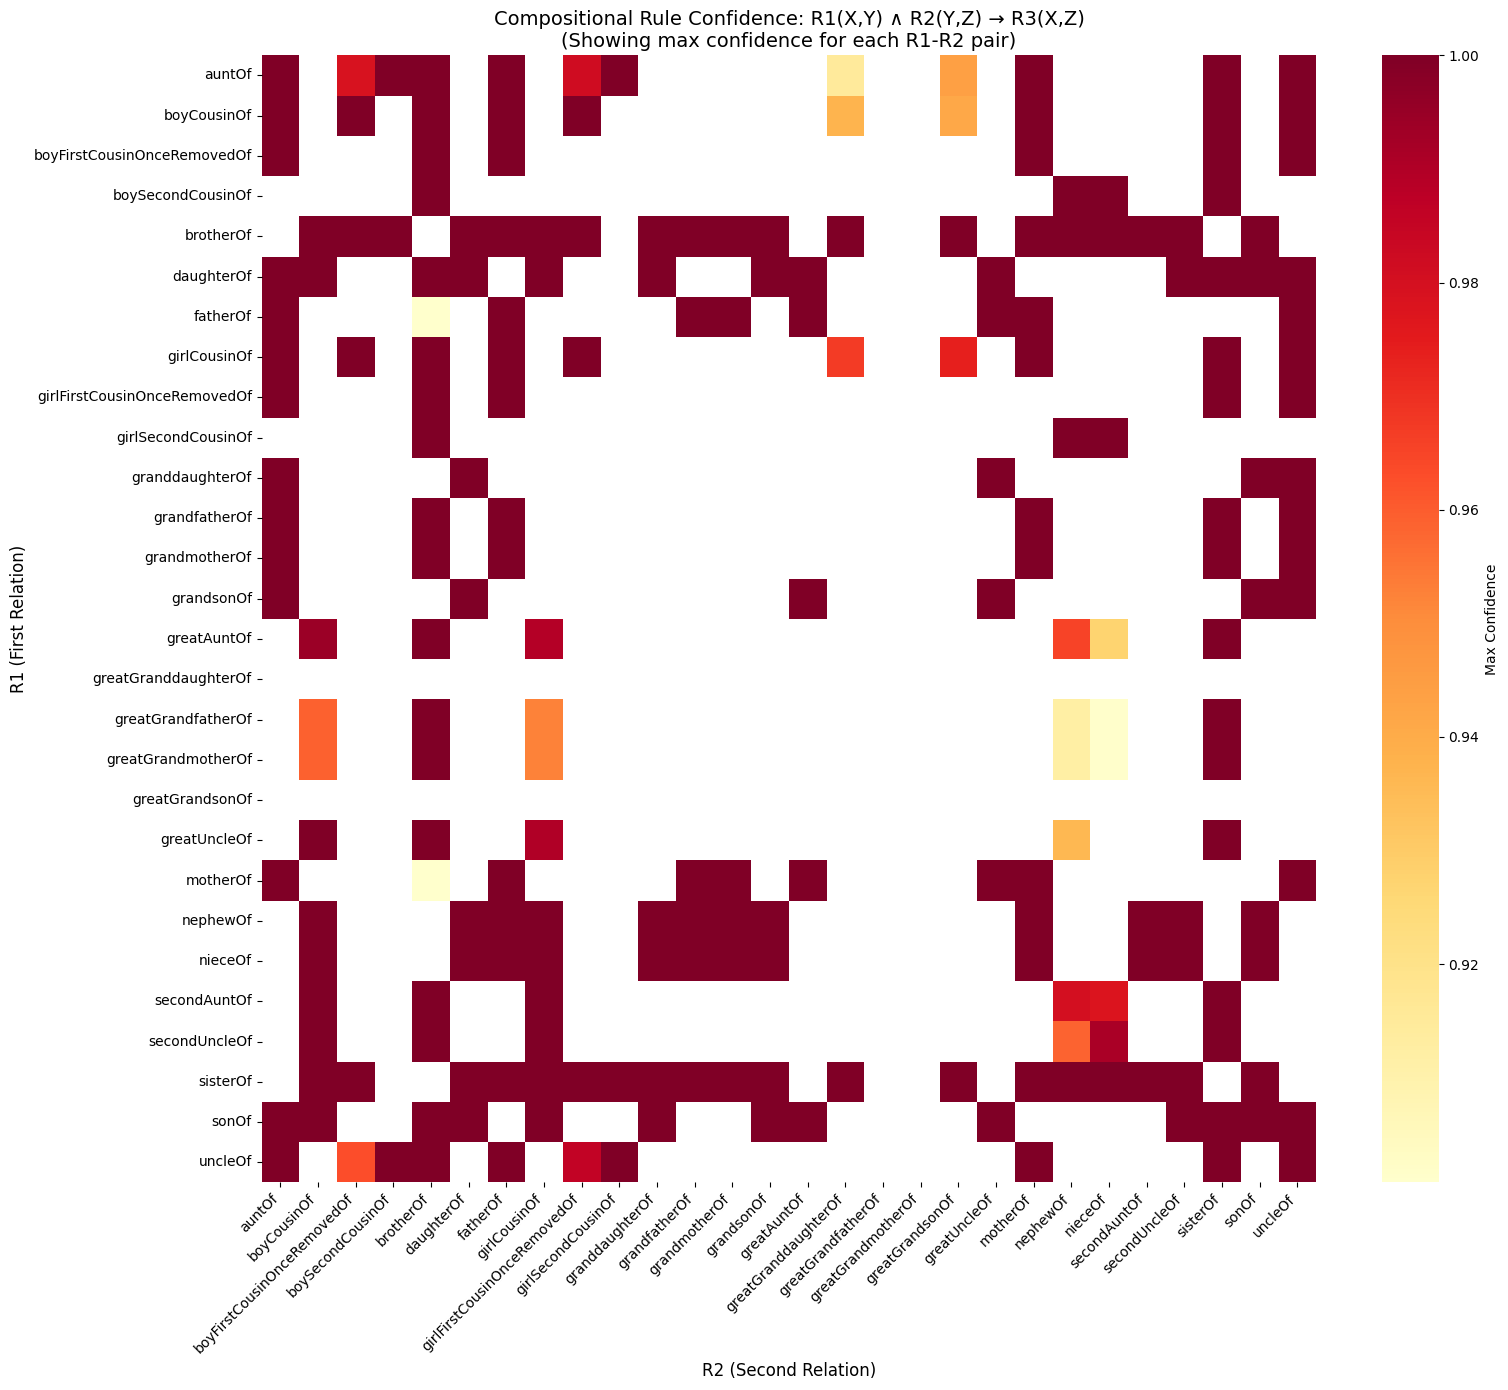


Relation Participation in High-Confidence Rules:
--------------------------------------------------

Most common as R1 (first relation in chain):
  sisterOf: 19 rules
  brotherOf: 19 rules
  daughterOf: 13 rules
  sonOf: 13 rules
  nephewOf: 12 rules

Most common as R2 (second relation in chain):
  brotherOf: 18 rules
  sisterOf: 17 rules
  auntOf: 14 rules
  uncleOf: 14 rules
  fatherOf: 14 rules

Most common as R3 (inferred relation):
  secondAuntOf: 16 rules
  secondUncleOf: 16 rules
  boyFirstCousinOnceRemovedOf: 14 rules
  girlFirstCousinOnceRemovedOf: 14 rules
  greatGrandmotherOf: 12 rules


In [23]:
# === VISUALIZATION: Rule Mining Heatmap ===

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("="*70)
print("VISUALIZATION: Compositional Rule Patterns")
print("="*70)

# Create a matrix of max confidence for each (R1, R2) pair
relations_list = sorted(df['relation'].unique())

# Build confidence matrix
conf_matrix = np.zeros((len(relations_list), len(relations_list)))
rule_exists = np.zeros((len(relations_list), len(relations_list)))

for rule in compositional_rules:
    r1_idx = relations_list.index(rule['r1'])
    r2_idx = relations_list.index(rule['r2'])
    conf_matrix[r1_idx, r2_idx] = max(conf_matrix[r1_idx, r2_idx], rule['confidence'])
    rule_exists[r1_idx, r2_idx] = 1

# Plot heatmap
plt.figure(figsize=(16, 14))
mask = conf_matrix == 0  # Mask cells with no high-confidence rules

sns.heatmap(conf_matrix, 
            xticklabels=relations_list, 
            yticklabels=relations_list,
            cmap='YlOrRd',
            mask=mask,
            annot=False,
            cbar_kws={'label': 'Max Confidence'})

plt.xlabel('R2 (Second Relation)', fontsize=12)
plt.ylabel('R1 (First Relation)', fontsize=12)
plt.title('Compositional Rule Confidence: R1(X,Y) ∧ R2(Y,Z) → R3(X,Z)\n(Showing max confidence for each R1-R2 pair)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Count how many high-confidence rules each relation participates in
print("\nRelation Participation in High-Confidence Rules:")
print("-"*50)
r1_counts = Counter(r['r1'] for r in compositional_rules if r['confidence'] >= 0.95)
r2_counts = Counter(r['r2'] for r in compositional_rules if r['confidence'] >= 0.95)
r3_counts = Counter(r['r3'] for r in compositional_rules if r['confidence'] >= 0.95)

print("\nMost common as R1 (first relation in chain):")
for rel, count in r1_counts.most_common(5):
    print(f"  {rel}: {count} rules")

print("\nMost common as R2 (second relation in chain):")
for rel, count in r2_counts.most_common(5):
    print(f"  {rel}: {count} rules")

print("\nMost common as R3 (inferred relation):")
for rel, count in r3_counts.most_common(5):
    print(f"  {rel}: {count} rules")